# 环境

In [34]:
import os
import time

import matplotlib.pylab as plt
import numpy as np
from scipy.io import wavfile
from silero_vad import load_silero_vad, get_speech_timestamps, VADIterator
# from ten_vad import TenVad
import torch
import tqdm

def calculate_db(chunk):
    rms = np.sqrt(np.mean(np.square(chunk)))
    return 20 * np.log10(rms + 1e-7) if rms > 0 else -np.inf

model = load_silero_vad(onnx=True)
prob_model = load_silero_vad(onnx=True)
SAMPLING_RATE = 16000
window_size_samples = 512 if SAMPLING_RATE == 16000 else 256
# ten_vad_instance = TenVad(window_size_samples, 0.5)

WAV_DIR_PATH = 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records'
WAV_FILES = filter(lambda x: not x.startswith('.'), os.listdir(WAV_DIR_PATH))
WAV_PATHS = [os.path.join(WAV_DIR_PATH, e) for e in sorted(WAV_FILES)]
WAV_PATHS

['exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-28-52-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-28-57-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-29-02-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-29-07-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-29-12-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-29-17-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-29-22-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-29-27-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/equidistant_audio_records/2025-08-19_10-29-32-478_5s_80000samples.wav',
 'exp_data/2025-08-19_10-28-52-314/eq

# 流式VAD样例

## 频谱分析

In [43]:
# 频谱分析参数
freq_bins = window_size_samples // 2 + 1  # 正频率区间的点数
frequencies = np.linspace(0, SAMPLING_RATE/2, freq_bins)  # 0到Nyquist频率
spectrogram_data = []      # 存储每个帧的分贝谱
dominant_frequencies = []  # 存储每个帧的主导频率

In [44]:
vad_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
vad_sec_iterator = VADIterator(model, sampling_rate=SAMPLING_RATE)
speech_probs = []
# ten_probs = []
wavs = []
# ten_wavs = []
for path in WAV_PATHS:
    sample_rate, wav = wavfile.read(path)
    # ten_wavs.append(wav)

    # 转换为float32并归一化
    if wav.dtype == np.int16:
        wav = wav.astype(np.float32) / 32768.0
    elif wav.dtype == np.float32:
        pass
    else:
        raise NotImplementedError('不被支持的数据类型')
    
    wav = torch.from_numpy(wav)
    # speech_timestamps = get_speech_timestamps(wav, model, sampling_rate=SAMPLING_RATE)
    # print(speech_timestamps)
    # print(wav.dtype, wav.shape)
    wavs.append(wav)
wav = torch.concat(wavs)
# ten_wav = np.concatenate(ten_wavs)

dbs = []
# for i in tqdm.trange(0, len(wav), window_size_samples):
temp_ts = time.time()
time_gaps = []
for i in range(0, len(wav), window_size_samples):
    time_gaps.append(time.time()-temp_ts)
    temp_ts = time.time()
    chunk = wav[i: i+ window_size_samples]
    # ten_chunk = ten_wav[i: i+ window_size_samples]

    int_chunk = chunk.numpy()
    db = calculate_db(int_chunk)
    dbs.append(db)

    chunk_np = chunk.numpy() * 32767 if hasattr(chunk, "numpy") else chunk
    fft_result = np.fft.fft(chunk_np, n=window_size_samples)
    fft_positive = fft_result[:freq_bins]
    magnitude_spectrum = np.abs(fft_positive)

    # 对每个频率bin用calculate_db求分贝谱
    spectrum_dbs = np.array([calculate_db(np.array([mag])) for mag in magnitude_spectrum])
    spectrogram_data.append(spectrum_dbs)

    # 主导频率：最大能量分贝点对应的频率
    peak_idx = np.argmax(spectrum_dbs)
    dominant_freq = frequencies[peak_idx]
    dominant_frequencies.append(dominant_freq)

    if len(chunk) < window_size_samples:
        break
    speech_dict = vad_iterator(chunk)
    if speech_dict:
        print(speech_dict)
        # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
    speech_dict = vad_sec_iterator(chunk, return_seconds=True)
    if speech_dict:
        print(speech_dict)
        # vad_iterator.reset_states() # reset model states after each audio, but 和不重置的效果不一致
        
    speech_prob = prob_model(chunk, SAMPLING_RATE).item()
    speech_probs.append(speech_prob)
    # out_probability, _ = ten_vad_instance.process(ten_chunk)
    # ten_probs.append(out_probability)

{'start': 61984}
{'start': 3.9}
{'end': 4.4}
{'end': 71136}
{'start': 102944}
{'start': 6.4}
{'end': 7.0}
{'end': 113120}
{'start': 21.3}
{'start': 341536}
{'end': 21.4}
{'end': 343520}
{'start': 387616}
{'start': 24.3}
{'end': 24.6}
{'end': 394208}
{'start': 583200}
{'start': 36.5}
{'end': 597984}
{'end': 37.4}
{'start': 750624}
{'start': 47.1}
{'end': 764896}
{'end': 47.8}
{'start': 933920}
{'end': 935392}
{'start': 945184}
{'start': 59.1}
{'end': 965088}
{'end': 60.3}
{'start': 977440}
{'start': 61.1}
{'end': 61.6}
{'end': 986592}
{'start': 989216}
{'start': 61.8}
{'end': 63.0}
{'end': 1009120}
{'start': 1038368}
{'start': 64.9}
{'end': 1047008}
{'end': 65.4}
{'start': 1075232}
{'start': 67.2}
{'end': 1080288}
{'end': 67.5}
{'start': 1083936}
{'start': 67.7}
{'end': 69.1}
{'end': 1106400}
{'start': 1111072}
{'start': 69.4}
{'end': 70.9}
{'end': 1134560}
{'start': 1161248}
{'start': 72.6}
{'end': 73.0}
{'end': 1168864}
{'start': 1173536}
{'start': 73.3}
{'end': 73.5}
{'end': 1177056}

## 人声概率在时间上分布

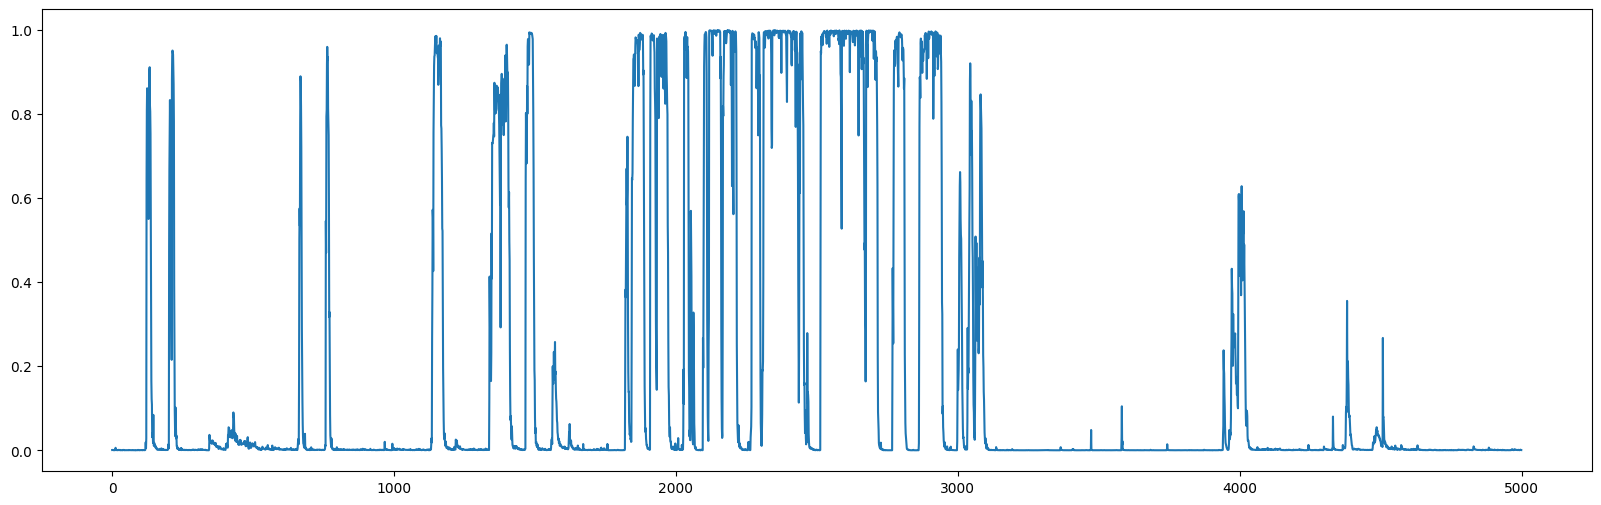

概率列表长度：5000


In [45]:
plt.figure(figsize=(20,6))
plt.plot(speech_probs)
# plt.plot(ten_probs)
plt.show()
print(f'概率列表长度：{len(speech_probs)}')

# print(speech_probs[:10])
# print(speech_probs[-10:])

## 分贝数
看来啸叫噪音不一定比原语音分贝低

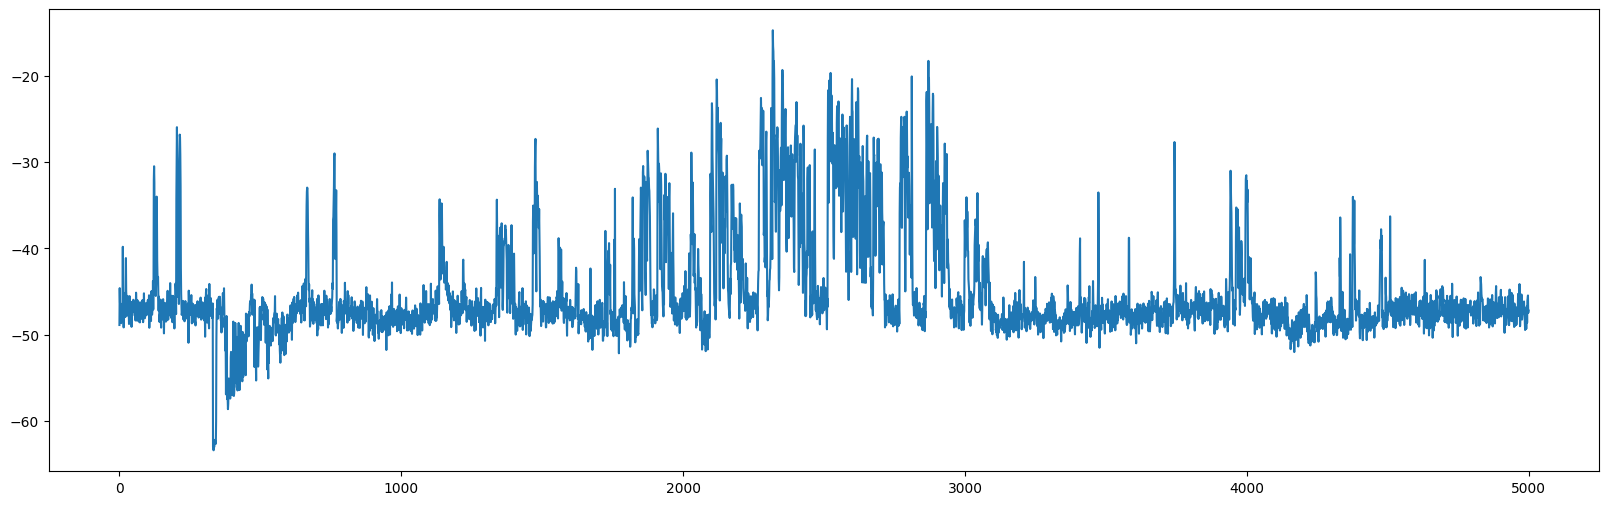

In [46]:
plt.figure(figsize=(20,6))
plt.plot(dbs)
plt.show()

## 频谱图

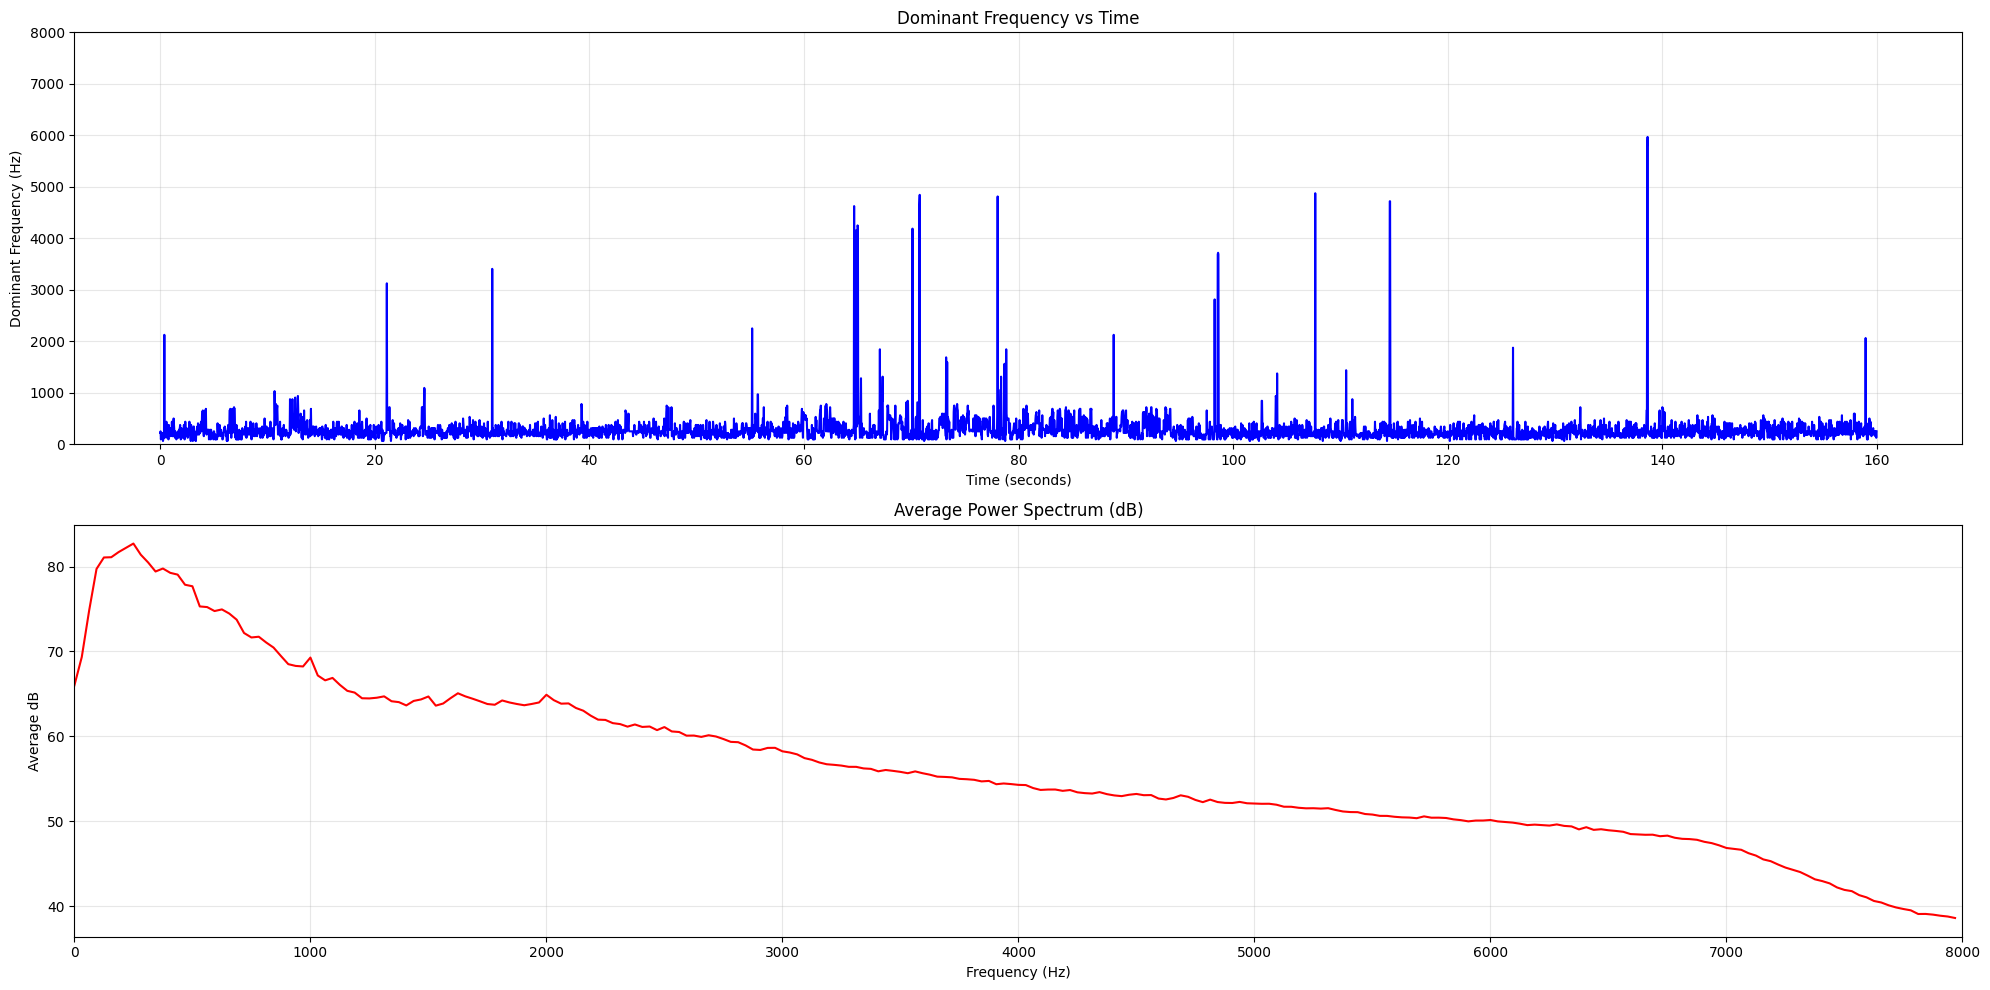

帧数: 5000
频率范围: 0 - 8000.0 Hz
总时长: 159.97 秒


In [39]:
import matplotlib.pyplot as plt
import numpy as np

spectrogram_matrix = np.array(spectrogram_data)
dominant_frequencies = np.array(dominant_frequencies)
time_axis = np.arange(len(dominant_frequencies)) * window_size_samples / SAMPLING_RATE

plt.figure(figsize=(20, 10))

# 1. 时频图（时间-主导频率）
plt.subplot(2, 1, 1)
plt.plot(time_axis, dominant_frequencies, 'b-', linewidth=1.5)
plt.xlabel('Time (seconds)')
plt.ylabel('Dominant Frequency (Hz)')
plt.title('Dominant Frequency vs Time')
plt.grid(True, alpha=0.3)
plt.ylim(0, SAMPLING_RATE/2)

# 2. 平均分贝谱
plt.subplot(2, 1, 2)
avg_db_per_freq = np.mean(spectrogram_matrix, axis=0)
plt.plot(frequencies, avg_db_per_freq, 'r-', linewidth=1.5)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Average dB')
plt.title('Average Power Spectrum (dB)')
plt.grid(True, alpha=0.3)
plt.xlim(0, SAMPLING_RATE/2)

plt.tight_layout()
plt.show()

print(f"帧数: {len(dominant_frequencies)}")
print(f"频率范围: 0 - {SAMPLING_RATE/2} Hz")
print(f"总时长: {time_axis[-1]:.2f} 秒")

## 延迟统计
< 1.2ms

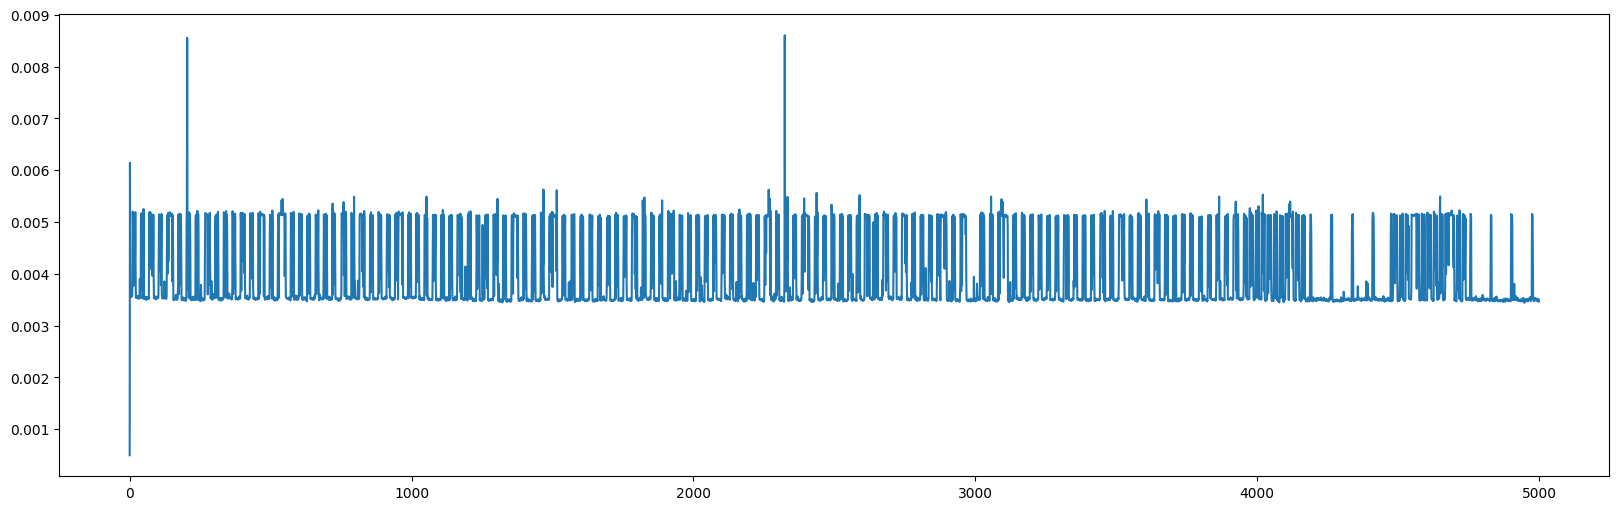

In [40]:
plt.figure(figsize=(20,6))
plt.plot(time_gaps)
plt.show()

In [41]:
sum(time_gaps)

19.982847690582275